# Project Solar

## Data Verkenning

In [1]:
# Importing the necessary packages
import numpy as np                                  # "Scientific computing"
import scipy.stats as stats                         # Statistical tests

import pandas as pd                                 # Data Frame
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt                     # Basic visualisation

### Zonnepanelen power output dataset

#### Importeren en visualisatie

In [125]:
power = pd.read_csv('https://raw.githubusercontent.com/HOGENT-ML/course/main/datasets/solar.csv')
power

,timestamp,kwh
0,2023-03-11 16:00:10.160454+01,0.5400
1,2023-03-11 17:00:10.217795+01,1.0200
2,2023-03-11 18:00:10.284064+01,1.1700
3,2023-03-11 19:00:10.224836+01,1.1800
4,2023-03-11 20:00:10.201847+01,1.1800
...,...,...
9700,2024-04-19 06:00:10.326636+02,2417.3321
9701,2024-04-19 07:00:10.424826+02,2417.3321
9702,2024-04-19 08:00:10.360449+02,2417.3336
9703,2024-04-19 09:00:10.437154+02,2417.3701


In [126]:
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  9705 non-null   object 
 1   kwh        9705 non-null   float64
dtypes: float64(1), object(1)
memory usage: 151.8+ KB


In [127]:
power['timestamp'] = pd.to_datetime(power['timestamp'], utc=True)

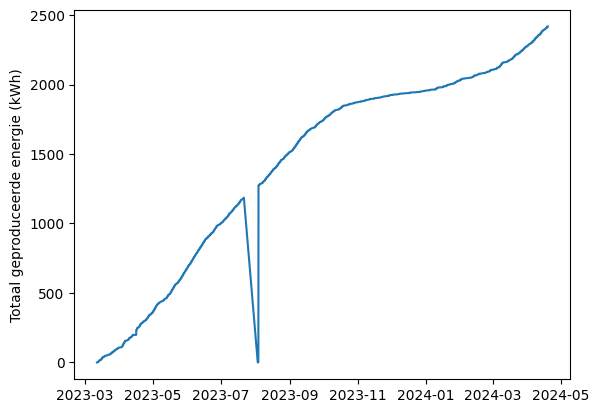

In [128]:
plt.plot(power['timestamp'], power['kwh'])
plt.ylabel('Totaal geproduceerde energie (kWh)')
plt.show()

We zien dat de kwh een cumulatieve meting is, de curve is monotoon stijgend. Er blijkt wel iets misgelopen te zijn in augustus 2023.

#### Onderzoek anomalie

In [129]:
power['kwh_per_hour'] = power['kwh'].diff().fillna(0)

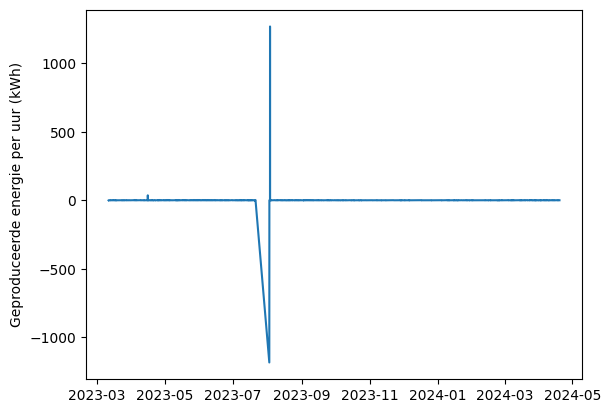

In [130]:
plt.plot(power['timestamp'], power['kwh_per_hour'])
plt.ylabel('Geproduceerde energie per uur (kWh)')
plt.show()

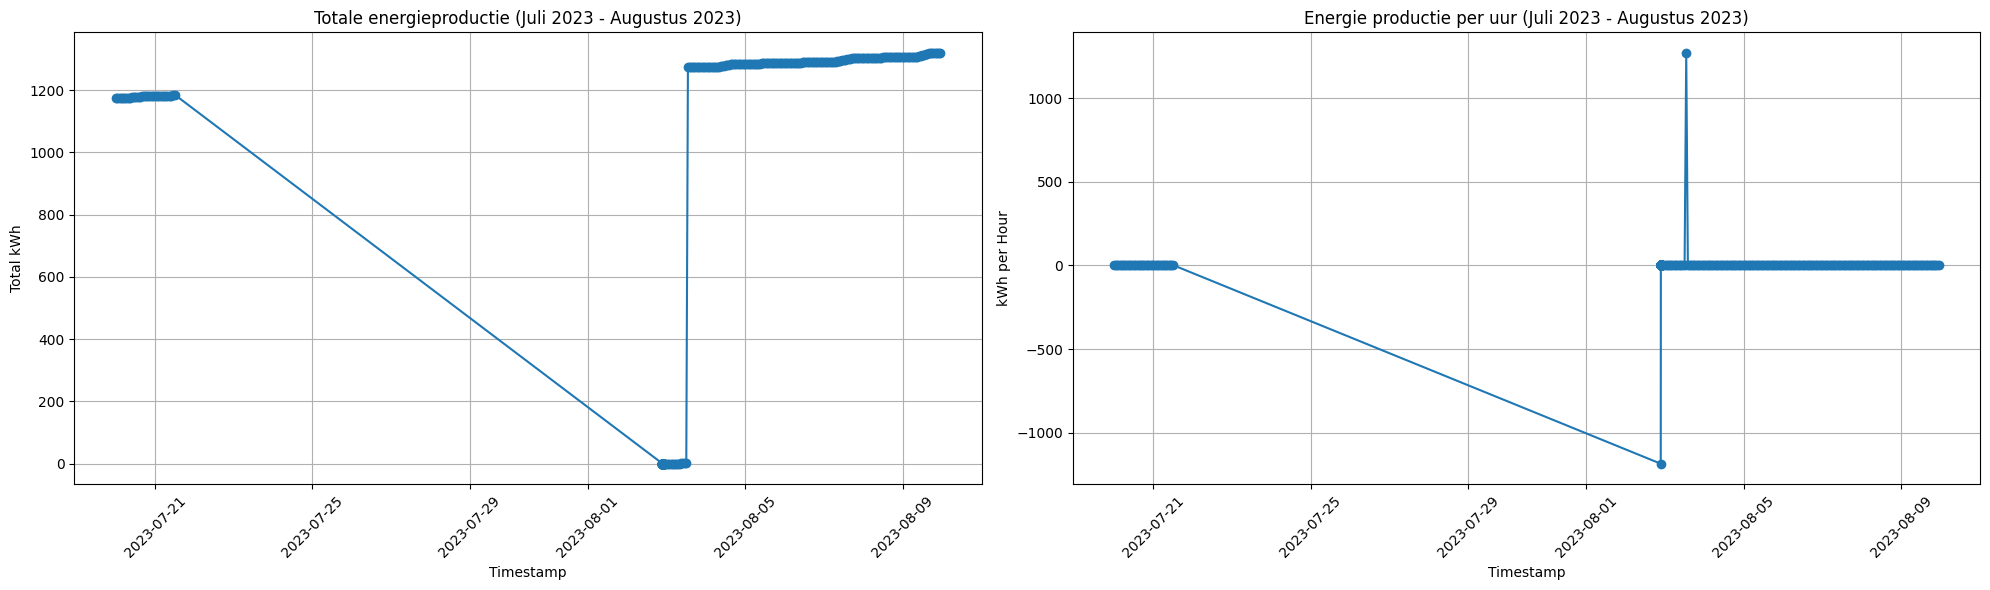

In [131]:
# Define the date range
start_date = pd.Timestamp('2023-07-20', tz='UTC')
end_date = pd.Timestamp('2023-08-10', tz='UTC')

power_augustus = power[(power['timestamp'] >= start_date) & (power['timestamp'] < end_date)]

# Create a figure with two subplots next to each other
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

# Plot total energy production
axes[0].plot(power_augustus['timestamp'], power_augustus['kwh'], marker='o', linestyle='-')
axes[0].set_xlabel('Timestamp')
axes[0].set_ylabel('Total kWh')
axes[0].set_title('Totale energieproductie (Juli 2023 - Augustus 2023)')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Plot hourly energy production
axes[1].plot(power_augustus['timestamp'], power_augustus['kwh_per_hour'], marker='o', linestyle='-')
axes[1].set_xlabel('Timestamp')
axes[1].set_ylabel('kWh per Hour')
axes[1].set_title('Energie productie per uur (Juli 2023 - Augustus 2023)')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In de figuur is te zien dat er heel wat waarden ontbreken tussen eind juli en begin augustus. Vervolgens zien we rond 3 augustus dat er gedurende een paar uur de totale energieproductie tot dat punt rond de nul hangt tot het op 1 uur tijd gecorrigeert wordt.

In [132]:
end_of_july = pd.Timestamp('2023-07-31 23:59:59', tz='UTC')
july_data = power[(power['timestamp'] >= start_date) & (power['timestamp'] <= end_of_july)]
last_timestamp_july = july_data['timestamp'].max()
print("Last timestamp in July before the blackout:", last_timestamp_july)

Last timestamp in July before the blackout: 2023-07-21 12:00:11.423424+00:00


In [133]:
power_correcties = power[abs(power['kwh_per_hour']) > 100]
power_correcties

,timestamp,kwh,kwh_per_hour
3166,2023-08-02 21:27:27.552237+00:00,0.0000,-1185.1582
3478,2023-08-03 13:00:12.358859+00:00,1272.9856,1269.9656


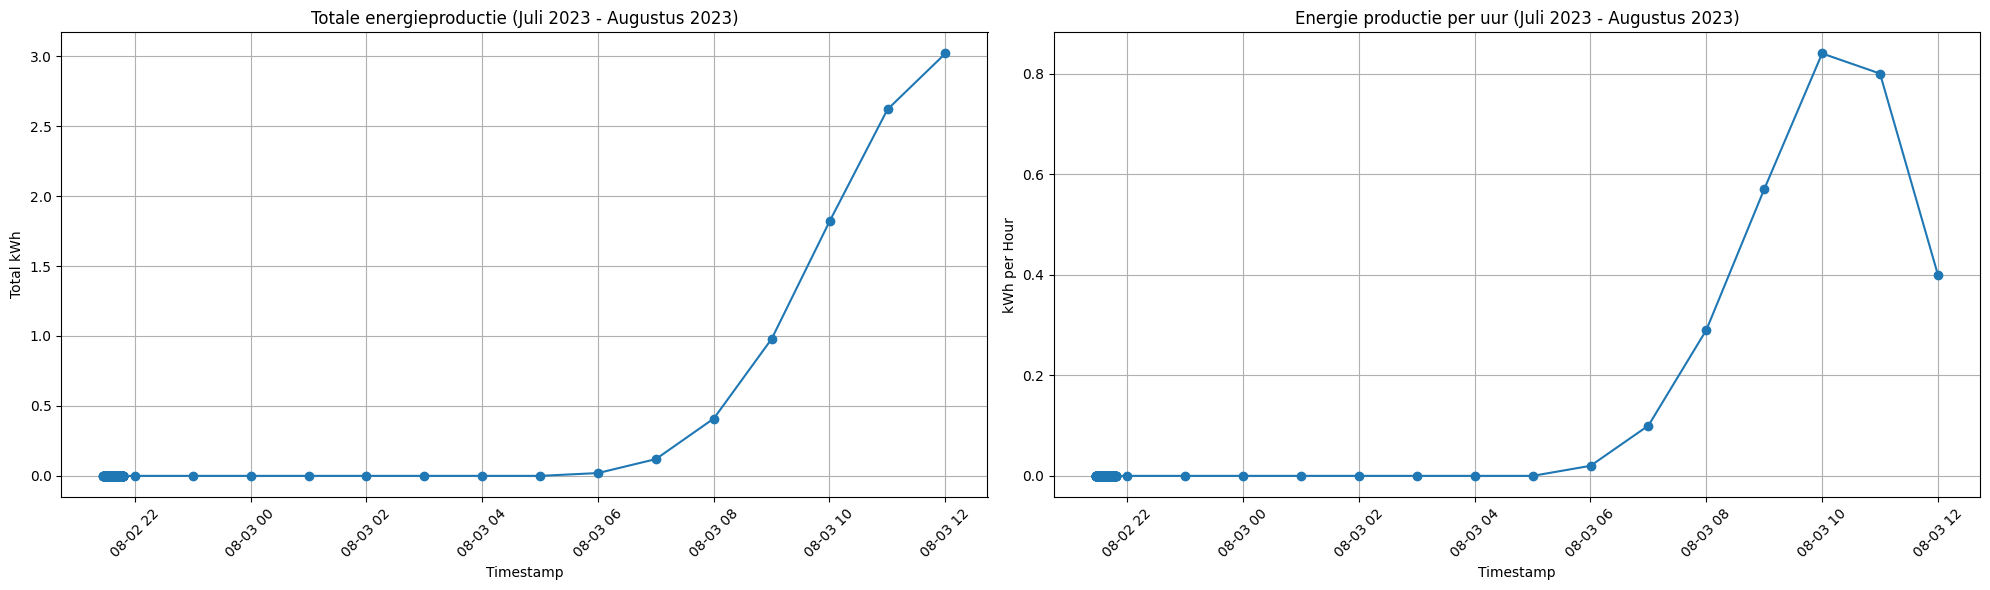

In [134]:
power_anomalie = power[(power['timestamp'] > power_correcties['timestamp'].iloc[0]) & (power['timestamp'] < power_correcties['timestamp'].iloc[-1])]

# Create a figure with two subplots next to each other
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

# Plot total energy production
axes[0].plot(power_anomalie['timestamp'], power_anomalie['kwh'], marker='o', linestyle='-')
axes[0].set_xlabel('Timestamp')
axes[0].set_ylabel('Total kWh')
axes[0].set_title('Totale energieproductie (Juli 2023 - Augustus 2023)')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Plot hourly energy production
axes[1].plot(power_anomalie['timestamp'], power_anomalie['kwh_per_hour'], marker='o', linestyle='-')
axes[1].set_xlabel('Timestamp')
axes[1].set_ylabel('kWh per Hour')
axes[1].set_title('Energie productie per uur (Juli 2023 - Augustus 2023)')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Het ziet ernaar uit dat de installatie gestopt is met het registreren van de power input op 2023-07-21 12:00:11.423424+00:00. Op 2023-08-02 21:27:27.552237+00:00, start de installatie terug op en wordt de totale energie productie op 0 gezet. Vervolgens werkt alles normaal voor een paar uur tot op 2023-08-03 13:00:12.358859+00:00 een correctie uitgevoerd wordt naar het echte niveau van de totale energie productie.

#### Opkuisen van data

In [135]:
# Foute metingen verwijderen
power_filtered = power[(power['kwh_per_hour'] > 0) & (power['kwh_per_hour'] < 100)]

# Outliers verwijderen
mean = power_filtered['kwh_per_hour'].mean()
std = power_filtered['kwh_per_hour'].std()

power_filtered = power_filtered[(power_filtered['kwh_per_hour'] > mean - 3*std) & (power_filtered['kwh_per_hour'] < mean + 3*std)]


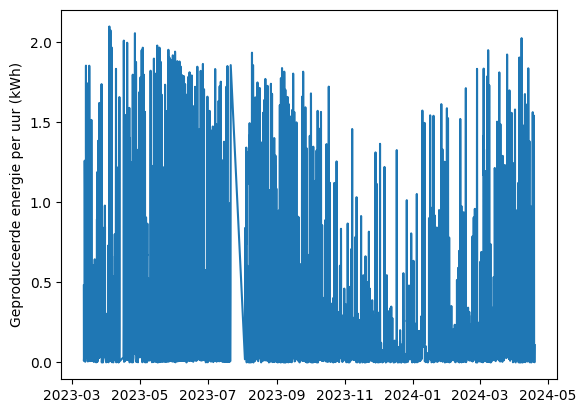

In [136]:
plt.plot(power_filtered['timestamp'], power_filtered['kwh_per_hour'])
plt.ylabel('Geproduceerde energie per uur (kWh)')
plt.show()

In [137]:
power_filtered['date'] = power_filtered['timestamp'].dt.date
daily_output = power_filtered.groupby('date')['kwh_per_hour'].sum().reset_index()
daily_output.columns = ['date', 'daily_kwh']

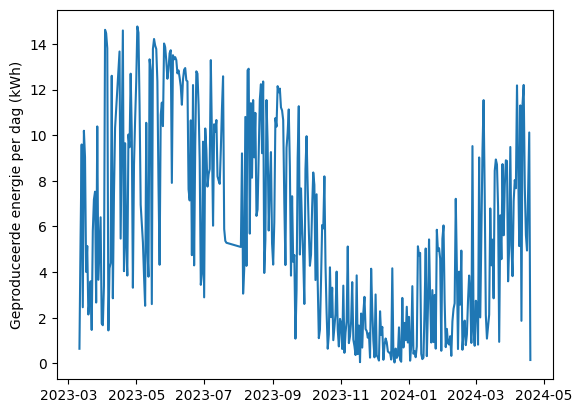

In [138]:
plt.plot(daily_output['date'], daily_output['daily_kwh'])
plt.ylabel('Geproduceerde energie per dag (kWh)')
plt.show()

Hier is duidelijk het effect van de seizoenen zichtbaar in de energieproductie per dag. Rond de zomerzonnewende (21 juni), is er een duidelijke piek in de data. Dit is logisch aangezien dit de dagen zijn met het grootste aantal uren daglicht. Rond de winterzonnewende (21 december), is er dan weer een zichtbaar dal aangezien hier de zon het minste uren per dag schijnt.

#### Onderzoek overgang zomeruur/winteruur

In [123]:
overgang_zomeruur_2023 = power[(power['timestamp'] >= '2023-03-25 23:00:00') & (power['timestamp'] <= '2023-03-26 06:00:00')]
overgang_zomeruur_2023

,timestamp,kwh,kwh_per_hour
344,2023-03-25 23:00:10.610864+00:00,77.5264,0.0
345,2023-03-26 00:00:10.658676+00:00,77.5264,0.0
346,2023-03-26 01:00:10.903616+00:00,77.5264,0.0
347,2023-03-26 02:00:10.762881+00:00,77.5264,0.0
348,2023-03-26 03:00:10.625843+00:00,77.5264,0.0
349,2023-03-26 04:00:10.651412+00:00,77.5264,0.0
350,2023-03-26 05:00:10.903797+00:00,77.5264,0.0


In [124]:
overgang_winteruur_2023 = power[(power['timestamp'] >= '2023-10-28 23:00:00') & (power['timestamp'] <= '2023-10-29 06:00:00')]
overgang_winteruur_2023

,timestamp,kwh,kwh_per_hour
5552,2023-10-28 23:00:10.888879+00:00,1869.3002,0.0
5553,2023-10-29 00:00:10.770127+00:00,1869.3002,0.0


In [139]:
overgang_zomeruur_2024 = power[(power['timestamp'] >= '2023-03-30 23:00:00') & (power['timestamp'] <= '2023-03-31 06:00:00')]
overgang_zomeruur_2024

,timestamp,kwh,kwh_per_hour
464,2023-03-30 23:00:10.742093+00:00,105.6255,0.0
465,2023-03-31 00:00:10.643216+00:00,105.6255,0.0
466,2023-03-31 01:00:10.687063+00:00,105.6255,0.0
467,2023-03-31 02:00:10.685025+00:00,105.6255,0.0
468,2023-03-31 03:00:10.677648+00:00,105.6255,0.0
469,2023-03-31 04:00:10.679560+00:00,105.6255,0.0
470,2023-03-31 05:00:10.973293+00:00,105.6255,0.0


Er zijn geen verschuivingen te zien, dat is logisch omdat de metingen werden gedaan in UTC (Universal Time Coordinated). UTC tijd is gelijk aan wintertijd en houdt geen rekening met zomertijd.

### Weerstation dataset

#### Importeren en visualisatie

In [153]:
weather_big = pd.read_csv('https://raw.githubusercontent.com/HOGENT-ML/course/main/datasets/weather.csv')
weather_big

,FID,the_geom,code,timestamp,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,...,wind_speed_unit,wind_direction,wind_peak_speed,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness
0,synop_data.6418.2023-03-01 09:00:00+00,POINT (51.347375 3.201846),6418,2023-03-01T09:00:00,NaN,NaN,4.9,NaN,NaN,NaN,...,1,50.0,9.4,54.3,NaN,1029.7,1028.0,NaN,NaN,0.0
1,synop_data.6414.2023-03-01 09:00:00+00,POINT (50.90398 3.121692),6414,2023-03-01T09:00:00,NaN,NaN,2.1,NaN,NaN,NaN,...,1,44.7,7.5,73.7,NaN,1029.3,1025.9,NaN,NaN,NaN
2,synop_data.6407.2023-03-01 09:00:00+00,POINT (51.200341 2.887306),6407,2023-03-01T09:00:00,NaN,NaN,3.3,NaN,NaN,NaN,...,1,60.0,7.0,NaN,NaN,1029.6,1029.0,NaN,NaN,1.0
3,synop_data.6434.2023-03-01 09:00:00+00,POINT (50.980293 3.816003),6434,2023-03-01T09:00:00,NaN,NaN,1.6,NaN,NaN,-10.0,...,1,71.6,5.9,70.9,NaN,1029.4,1027.3,NaN,NaN,NaN
4,synop_data.6434.2023-03-01 10:00:00+00,POINT (50.980293 3.816003),6434,2023-03-01T10:00:00,NaN,NaN,3.0,NaN,NaN,NaN,...,1,56.0,7.6,60.8,NaN,1028.8,1026.7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39835,synop_data.6407.2024-04-19 07:00:00+00,POINT (51.200341 2.887306),6407,2024-04-19T07:00:00,NaN,NaN,10.6,NaN,NaN,NaN,...,1,290.0,14.0,NaN,NaN,1013.5,1012.8,NaN,NaN,8.0
39836,synop_data.6434.2024-04-19 08:00:00+00,POINT (50.980293 3.816003),6434,2024-04-19T08:00:00,NaN,NaN,10.0,NaN,NaN,NaN,...,1,276.5,9.8,90.5,NaN,1012.7,1010.7,NaN,NaN,NaN
39837,synop_data.6407.2024-04-19 08:00:00+00,POINT (51.200341 2.887306),6407,2024-04-19T08:00:00,NaN,NaN,10.8,NaN,NaN,NaN,...,1,290.0,15.0,NaN,NaN,1013.2,1012.6,NaN,NaN,8.0
39838,synop_data.6414.2024-04-19 08:00:00+00,POINT (50.90398 3.121692),6414,2024-04-19T08:00:00,NaN,NaN,9.9,NaN,NaN,NaN,...,1,273.3,12.4,89.7,NaN,1013.6,1010.4,NaN,NaN,NaN


In [154]:
weather_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39840 entries, 0 to 39839
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FID                          39840 non-null  object 
 1   the_geom                     39840 non-null  object 
 2   code                         39840 non-null  int64  
 3   timestamp                    39840 non-null  object 
 4   precip_quantity              6291 non-null   float64
 5   precip_range                 6417 non-null   float64
 6   temp                         39840 non-null  float64
 7   temp_min                     1660 non-null   float64
 8   temp_max                     1657 non-null   float64
 9   temp_grass_min               1189 non-null   float64
 10  wind_speed                   39827 non-null  float64
 11  wind_speed_unit              39840 non-null  int64  
 12  wind_direction               39414 non-null  float64
 13  wind_peak_speed 

In [156]:
weather_big['timestamp'] = pd.to_datetime(weather_big['timestamp'])

In de forecast.csv staan enkel de volgende 5 kolommen: timestamp, temp, pressure, cloudiness, humidity_relative. We houden dus enkel rekening met die kolommen voor het model en verwijderen de overigen. Verder nemen we de code van het weerstation ook mee.

In [158]:
weather = weather_big[['timestamp', 'code', 'temp', 'pressure', 'cloudiness', 'humidity_relative']]
weather

,timestamp,code,temp,pressure,cloudiness,humidity_relative
0,2023-03-01 09:00:00+00:00,6418,4.9,1029.7,0.0,54.3
1,2023-03-01 09:00:00+00:00,6414,2.1,1029.3,NaN,73.7
2,2023-03-01 09:00:00+00:00,6407,3.3,1029.6,1.0,NaN
3,2023-03-01 09:00:00+00:00,6434,1.6,1029.4,NaN,70.9
4,2023-03-01 10:00:00+00:00,6434,3.0,1028.8,NaN,60.8
...,...,...,...,...,...,...
39835,2024-04-19 07:00:00+00:00,6407,10.6,1013.5,8.0,NaN
39836,2024-04-19 08:00:00+00:00,6434,10.0,1012.7,NaN,90.5
39837,2024-04-19 08:00:00+00:00,6407,10.8,1013.2,8.0,NaN
39838,2024-04-19 08:00:00+00:00,6414,9.9,1013.6,NaN,89.7


In de documentatie staat volgende informatie voor deze metingen:

- TEMP = air temperature at 1.5m in °C (hourly) 1 value every hour: average measured between (T – 11 min) and (T – 10 min)

- PRESSURE = air pressure at sea level (hPa) (hourly) measured between (T – 11 min) and (T – 10 min)

- CLOUDINESS = part of the sky covered in clouds (in octas) instantaneous

- HUMIDITY_RELATIVE = relative humidity of the air in % (hourly) average RH measured/calculated between (T – 11 min) and (T – 10 min)

We zien hier dat cloudiness een classificatie is met 8 mogelijkheden. Het zijn wel waarden die op elkaar volgen dus het is morgelijk om een OrdinalEncoder te gebruiken.

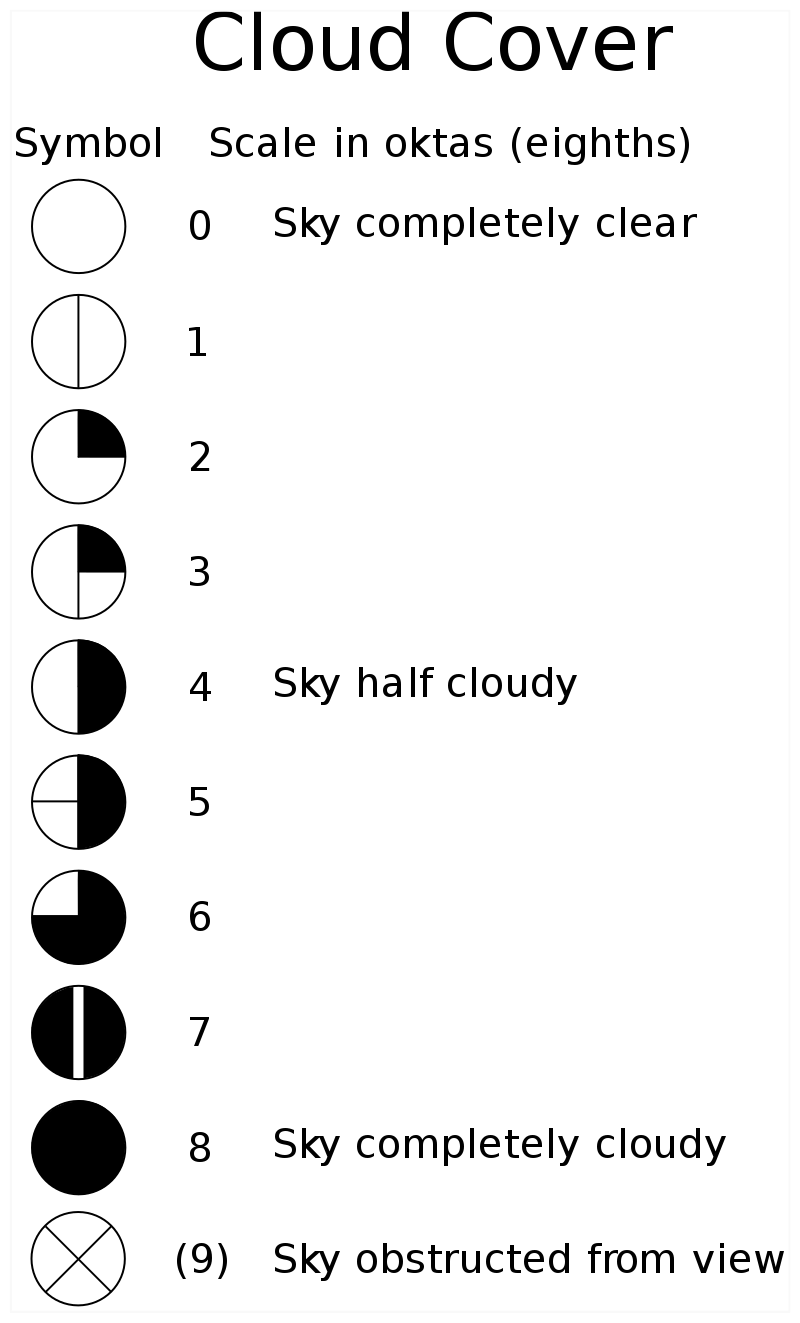

In [99]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39840 entries, 0 to 39839
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          39840 non-null  datetime64[ns, UTC]
 1   temp               39840 non-null  float64            
 2   pressure           39828 non-null  float64            
 3   cloudiness         15455 non-null  float64            
 4   humidity_relative  29880 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 1.5 MB


Uit het overzicht blijkt dat timestamp en temperatuur altijd ingevuld zijn er enkele ontbrekende waarden zijn bij pressure en dat er bij cloudiness en relative humidity vaak waarden ontbreken.

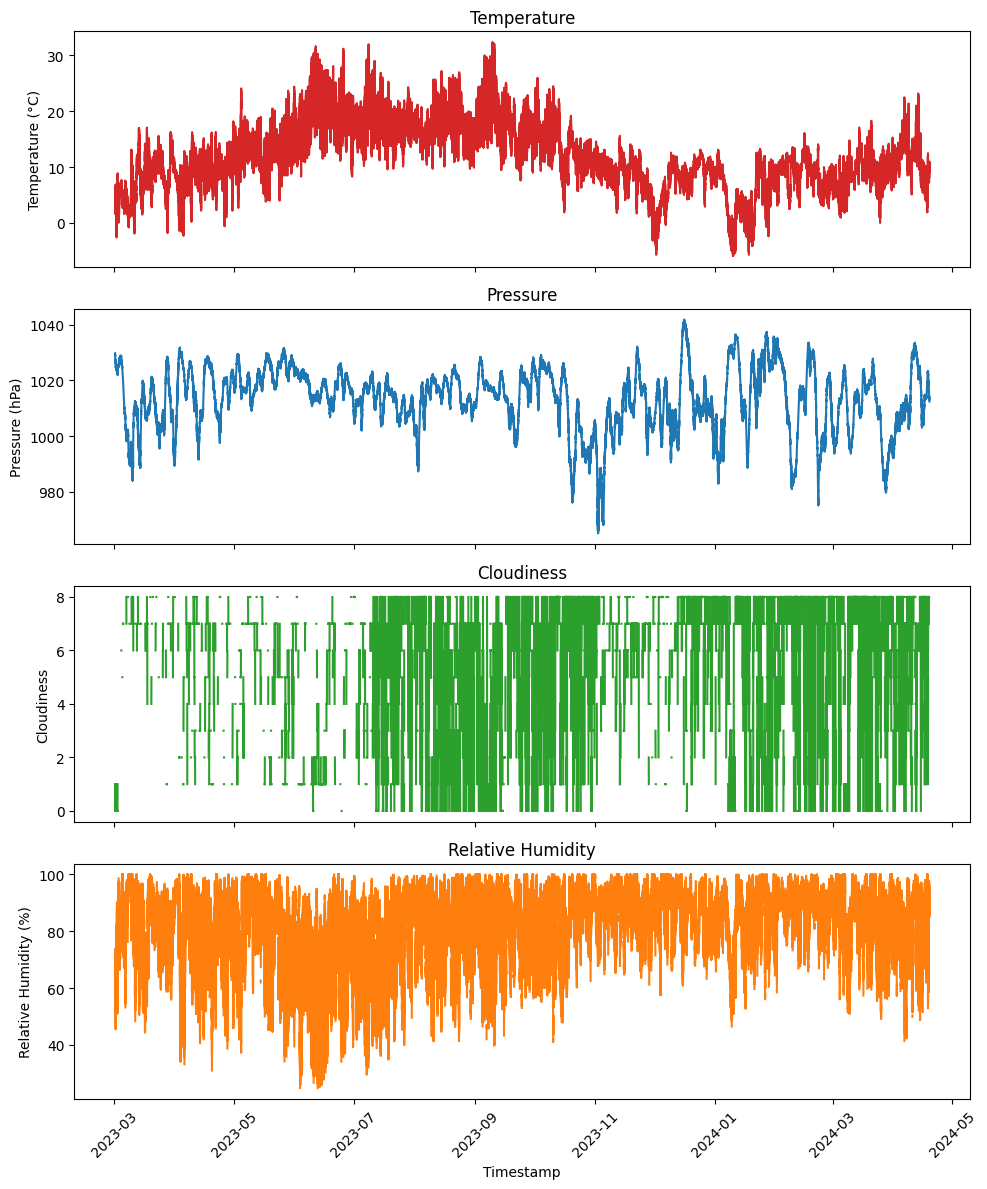

In [170]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plot each column on its respective subplot
axs[0].plot(weather['timestamp'], weather['temp'], color='tab:red')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_title('Temperature')

axs[1].plot(weather['timestamp'], weather['pressure'], color='tab:blue')
axs[1].set_ylabel('Pressure (hPa)')
axs[1].set_title('Pressure')

axs[2].plot(weather['timestamp'], weather['cloudiness'], color='tab:green')
axs[2].set_ylabel('Cloudiness')
axs[2].set_title('Cloudiness')

axs[3].plot(weather['timestamp'], weather['humidity_relative'], color='tab:orange')
axs[3].set_ylabel('Relative Humidity (%)')
axs[3].set_title('Relative Humidity')

# Set common labels
plt.xlabel('Timestamp')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


Er zijn enkele logische trends zichtbaar in de data:

- Temperature: In de zomermaanden is het gemiddeld warmer dan in de wintermaanden
- Pressure: In het najaar lijkt de luchtdruk een pak stabieler dan in het voorjaar.
- Cloudiness: Tijdens de herfst en lente lijkt het alsof het meer bewolkt is dan tijdens de zomer en winter. Echter er zijn veel velden niet ingevuld voor Cloudiness. Het zou kunnen zijn dat deze grafiek een vertekend beeld geeft omdat er enkel data ingevuld zijn in bepaalde periodes.
- Relative humidity: De relatieve luchtvochtigheid is behoorlijk constant al is er een duidelijk dip merkbaar rond juni en juli.

#### Data per weerstation

In [166]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39840 entries, 0 to 39839
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          39840 non-null  datetime64[ns, UTC]
 1   code               39840 non-null  int64              
 2   temp               39840 non-null  float64            
 3   pressure           39828 non-null  float64            
 4   cloudiness         15455 non-null  float64            
 5   humidity_relative  29880 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 1.8 MB


In [167]:
weather['code'].value_counts()

code
6418    9960
6414    9960
6407    9960
6434    9960
Name: count, dtype: int64

Elk weerstation heeft evenveel waarnemingen gedaan. 4 x 9960 = 39840

In [168]:
weather_station_1 = weather[weather['code'] == 6407]
weather_station_2 = weather[weather['code'] == 6414]
weather_station_3 = weather[weather['code'] == 6418]
weather_station_4 = weather[weather['code'] == 6434]

In [173]:
weather_station_1.info()
weather_station_2.info()
weather_station_3.info()
weather_station_4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9960 entries, 2 to 39837
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          9960 non-null   datetime64[ns, UTC]
 1   code               9960 non-null   int64              
 2   temp               9960 non-null   float64            
 3   pressure           9948 non-null   float64            
 4   cloudiness         9763 non-null   float64            
 5   humidity_relative  0 non-null      float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 544.7 KB
<class 'pandas.core.frame.DataFrame'>
Index: 9960 entries, 1 to 39838
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          9960 non-null   datetime64[ns, UTC]
 1   code               9960 non-null   int64              


De opsplitsing per weerstation onthult dat er een aantal instrumenten niet functioneren bij bepaalde weerstations:
 - Weerstation 1 (6407):
       - Temperatuur: 100% van de metingen
       - Luchtdruk: 99.8% van de metingen
       - Bewolking: 98.0% van de metingen
       - Luchtvochtigheid: 0.0% van de metingen
 - Weerstation 2 (6414):
       - Temperatuur: 100% van de metingen
       - Luchtdruk: 100% van de metingen
       - Bewolking: 0.0% van de metingen
       - Luchtvochtigheid: 100% van de metingen
 - Weerstation 3 (6418):
       - Temperatuur: 100% van de metingen
       - Luchtdruk: 100% van de metingen
       - Bewolking: 57.1% van de metingen
       - Luchtvochtigheid: 100% van de metingen
 - Weerstation 4 (6434):
       - Temperatuur: 100% van de metingen
       - Luchtdruk: 100% van de metingen
       - Bewolking: 0.0% van de metingen
       - Luchtvochtigheid: 100% van de metingen

Zo zien we dat bij weerstations 2 en 4 de bewolkingsmeter helemaal niet werkt en bij weerstation 3 slechts gedeeltelijk. Bij weerstation 1 is de luchtvochtigheidsmeter dan weer kapot.

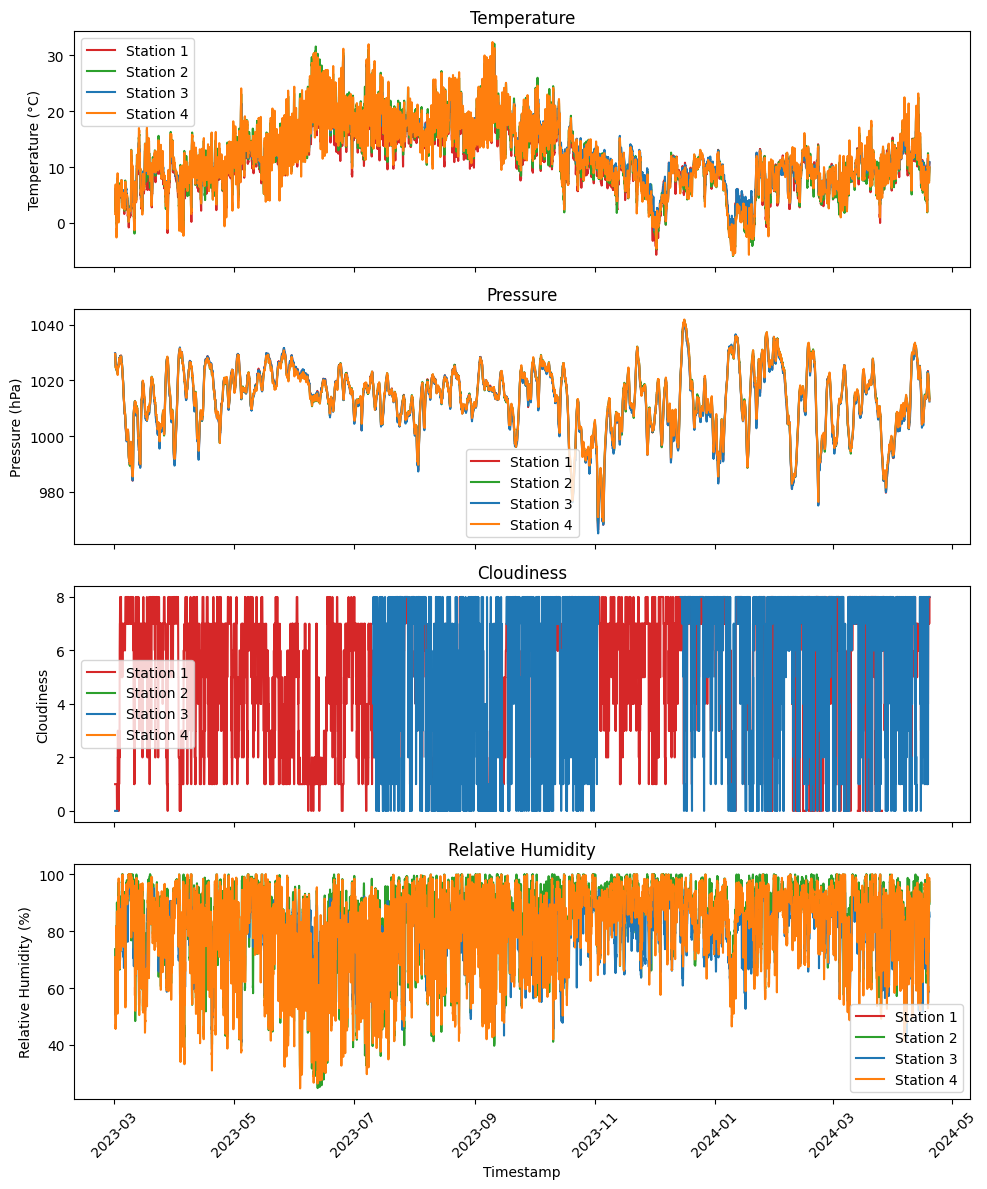

In [175]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

station_labels = ['Station 1', 'Station 2', 'Station 3', 'Station 4']

# Plot each column on its respective subplot
axs[0].plot(weather_station_1['timestamp'], weather_station_1['temp'], color='tab:red', label=station_labels[0])
axs[0].plot(weather_station_2['timestamp'], weather_station_2['temp'], color='tab:green', label=station_labels[1])
axs[0].plot(weather_station_3['timestamp'], weather_station_3['temp'], color='tab:blue', label=station_labels[2])
axs[0].plot(weather_station_4['timestamp'], weather_station_4['temp'], color='tab:orange', label=station_labels[3])
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_title('Temperature')
axs[0].legend()

axs[1].plot(weather_station_1['timestamp'], weather_station_1['pressure'], color='tab:red', label=station_labels[0])
axs[1].plot(weather_station_2['timestamp'], weather_station_2['pressure'], color='tab:green', label=station_labels[1])
axs[1].plot(weather_station_3['timestamp'], weather_station_3['pressure'], color='tab:blue', label=station_labels[2])
axs[1].plot(weather_station_4['timestamp'], weather_station_4['pressure'], color='tab:orange', label=station_labels[3])
axs[1].set_ylabel('Pressure (hPa)')
axs[1].set_title('Pressure')
axs[1].legend()


axs[2].plot(weather_station_1['timestamp'], weather_station_1['cloudiness'], color='tab:red', label=station_labels[0])
axs[2].plot(weather_station_2['timestamp'], weather_station_2['cloudiness'], color='tab:green', label=station_labels[1])
axs[2].plot(weather_station_3['timestamp'], weather_station_3['cloudiness'], color='tab:blue', label=station_labels[2])
axs[2].plot(weather_station_4['timestamp'], weather_station_4['cloudiness'], color='tab:orange', label=station_labels[3])
axs[2].set_ylabel('Cloudiness')
axs[2].set_title('Cloudiness')
axs[2].legend()


axs[3].plot(weather_station_1['timestamp'], weather_station_1['humidity_relative'], color='tab:red', label=station_labels[0])
axs[3].plot(weather_station_2['timestamp'], weather_station_2['humidity_relative'], color='tab:green', label=station_labels[1])
axs[3].plot(weather_station_3['timestamp'], weather_station_3['humidity_relative'], color='tab:blue', label=station_labels[2])
axs[3].plot(weather_station_4['timestamp'], weather_station_4['humidity_relative'], color='tab:orange', label=station_labels[3])
axs[3].set_ylabel('Relative Humidity (%)')
axs[3].set_title('Relative Humidity')
axs[3].legend()


# Set common labels
plt.xlabel('Timestamp')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

Het grootste verschil zien we in de Cloudiness grafiek. Het blijkt dat de waarden van station 3 zich clusteren in specifieke periodes.

#### Onderzoek overgang zomeruur/winteruur

In [148]:
overgang_zomeruur_2023_w = weather[(weather['timestamp'] >= '2023-03-25 23:00:00') & (weather['timestamp'] <= '2023-03-26 06:00:00')]
overgang_zomeruur_2023_w

,timestamp,temp,pressure,cloudiness,humidity_relative
2360,2023-03-25 23:00:00+00:00,8.3,1007.8,NaN,87.3
2361,2023-03-25 23:00:00+00:00,8.9,1008.6,NaN,91.0
2362,2023-03-25 23:00:00+00:00,7.0,1007.9,7.0,NaN
2363,2023-03-25 23:00:00+00:00,8.3,1008.8,NaN,88.0
2364,2023-03-26 00:00:00+00:00,9.0,1008.2,NaN,87.8
2365,2023-03-26 00:00:00+00:00,8.6,1007.0,NaN,89.4
2366,2023-03-26 00:00:00+00:00,7.5,1007.2,7.0,NaN
2367,2023-03-26 00:00:00+00:00,9.1,1007.7,NaN,87.8
2368,2023-03-26 01:00:00+00:00,8.6,1006.8,NaN,87.8
2369,2023-03-26 01:00:00+00:00,9.0,1006.6,NaN,89.3


### Zonsondergang dataset

#### Importeren en visualisatie

In [141]:
sunset = pd.read_excel('https://github.com/HOGENT-ML/course/raw/main/datasets/sunrise-sunset.xlsx')
sunset

,datum,Opkomst,Op ware middag,Ondergang
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00
...,...,...,...,...
726,2024-12-27,08:45:00,12:44:00,16:43:00
727,2024-12-28,08:45:00,12:44:00,16:44:00
728,2024-12-29,08:45:00,12:45:00,16:45:00
729,2024-12-30,08:45:00,12:45:00,16:46:00


In [142]:
sunset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datum           731 non-null    datetime64[ns]
 1   Opkomst         731 non-null    object        
 2   Op ware middag  731 non-null    object        
 3   Ondergang       731 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 23.0+ KB


Alle waarden voor alle kolommen zijn gekend. De datum kolom is reeds van het datetime type maar ditmaal is het niet UTC.

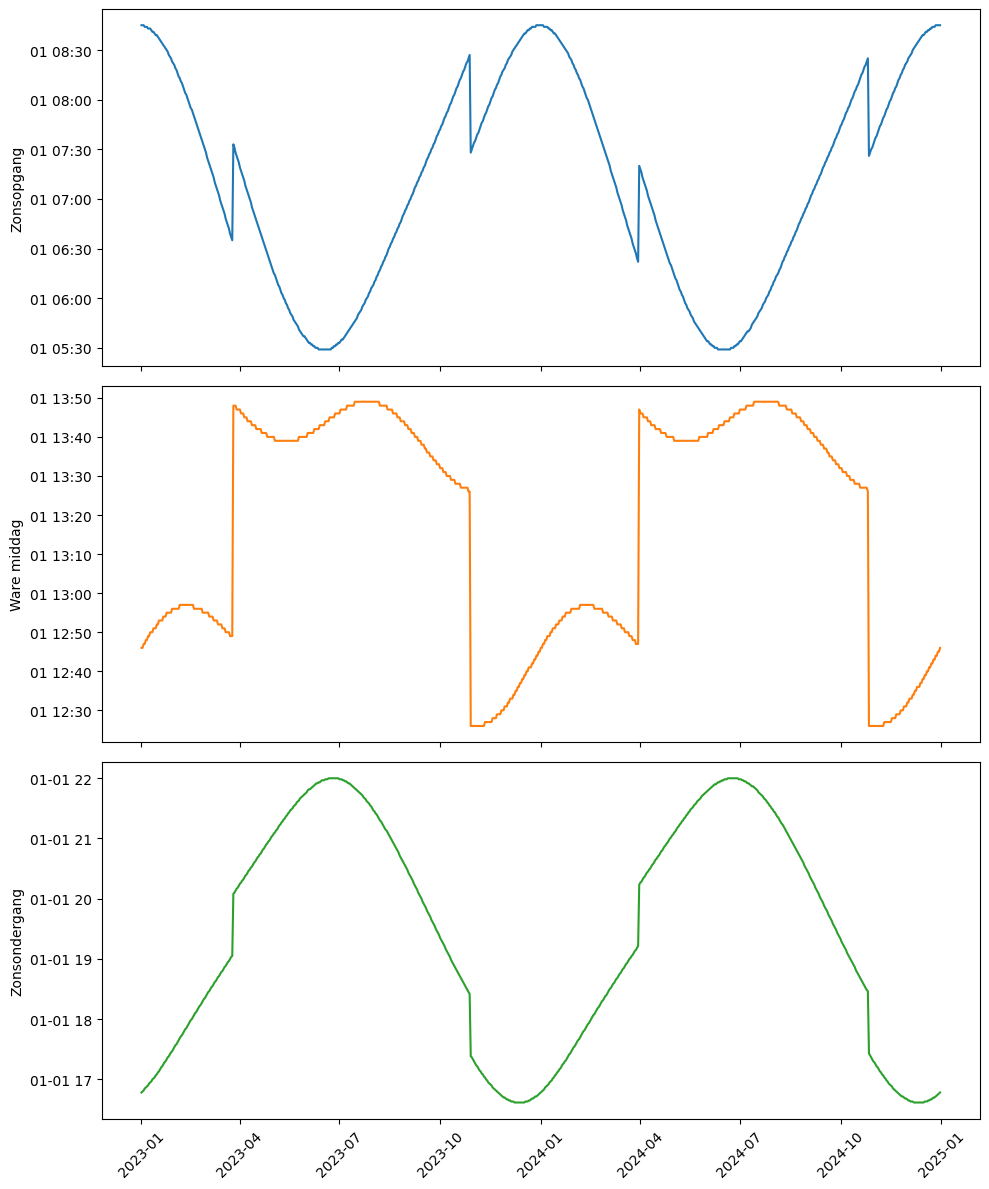

In [143]:
# Convert time columns to datetime objects
sunset['datum'] = pd.to_datetime(sunset['datum'], format='%Y-%m-%d')
sunset['Opkomst'] = pd.to_datetime(sunset['Opkomst'], format='%H:%M:%S')
sunset['Op ware middag'] = pd.to_datetime(sunset['Op ware middag'], format='%H:%M:%S')
sunset['Ondergang'] = pd.to_datetime(sunset['Ondergang'], format='%H:%M:%S')

# Create subplots for each column
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot each column on its respective subplot
axs[0].plot(sunset['datum'], sunset['Opkomst'], color='tab:blue')
axs[0].set_ylabel('Zonsopgang')

axs[1].plot(sunset['datum'], sunset['Op ware middag'], color='tab:orange')
axs[1].set_ylabel('Ware middag')

axs[2].plot(sunset['datum'], sunset['Ondergang'], color='tab:green')
axs[2].set_ylabel('Zonsondergang')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


Er is een periodiciteit zichtbaar in elke kolom. Het is eveneens duidelijk dat deze natuurlijke fenomenen normaal een sinusoidaal verloop hebben, echter wordt dit op vaste momenten verschoven door de overgangen van winter- en zomeruur.

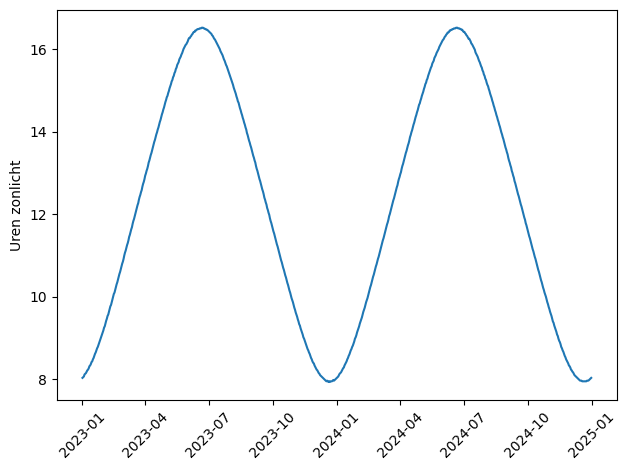

In [144]:
sunset['Uren zonlicht'] = (sunset['Ondergang'] - sunset['Opkomst']).dt.total_seconds() / 3600
plt.plot(sunset['datum'], sunset['Uren zonlicht'])
plt.ylabel('Uren zonlicht')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Door te kijken naar het totaal aan uren daglicht per dag wordt de hypothese bevestigd. Er is geen plotse verschuiving door meetfouten door het toekennen van timestamps die variëren met zomeruur en winteruur.

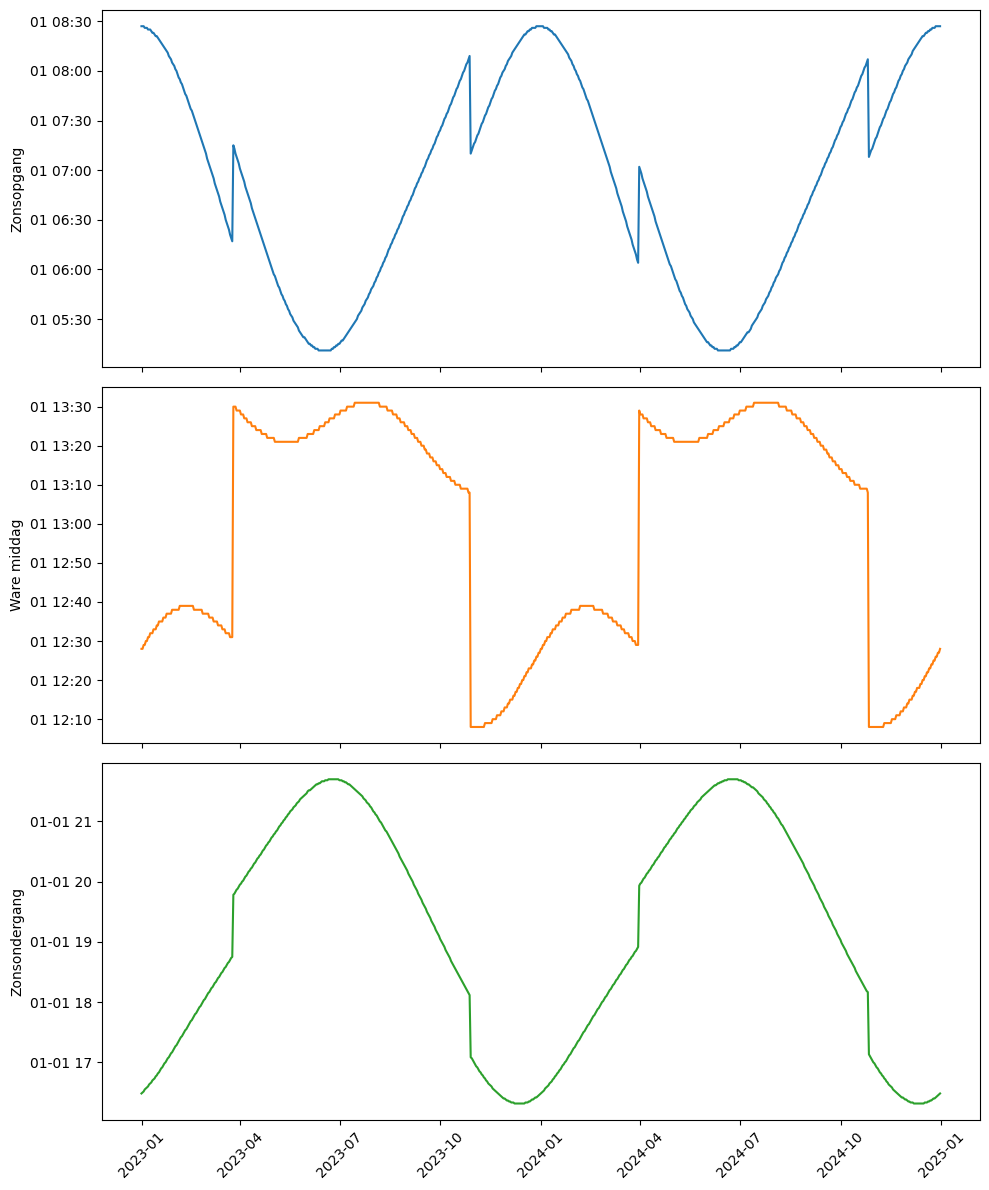

In [146]:
import pytz

local_tz = pytz.timezone('Europe/Brussels')

sunset['datum'] = sunset['datum'].dt.tz_localize(local_tz).dt.tz_convert(pytz.UTC)
sunset['Opkomst'] = sunset['Opkomst'].dt.tz_localize(local_tz).dt.tz_convert(pytz.UTC)
sunset['Op ware middag'] = sunset['Op ware middag'].dt.tz_localize(local_tz).dt.tz_convert(pytz.UTC)
sunset['Ondergang'] = sunset['Ondergang'].dt.tz_localize(local_tz).dt.tz_convert(pytz.UTC)

# Create subplots for each column
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot each column on its respective subplot
axs[0].plot(sunset['datum'], sunset['Opkomst'], color='tab:blue')
axs[0].set_ylabel('Zonsopgang')

axs[1].plot(sunset['datum'], sunset['Op ware middag'], color='tab:orange')
axs[1].set_ylabel('Ware middag')

axs[2].plot(sunset['datum'], sunset['Ondergang'], color='tab:green')
axs[2].set_ylabel('Zonsondergang')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   datum           731 non-null    datetime64[ns, UTC]
 1   Opkomst         731 non-null    datetime64[ns, UTC]
 2   Op ware middag  731 non-null    datetime64[ns, UTC]
 3   Ondergang       731 non-null    datetime64[ns, UTC]
 4   Uren zonlicht   731 non-null    float64            
dtypes: datetime64[ns, UTC](4), float64(1)
memory usage: 28.7 KB
